In [1]:
#checking version numbers for reprocibility checks
import yfinance as yf
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import scipy
import plotly
import statsmodels.api
print("yfinance version:", yf.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", matplotlib.__version__)
print("numpy version:", np.__version__)
print("seaborn version:", sns.__version__)
print("scipy version:", scipy.__version__)
print("plotly version:", plotly.__version__)
print('StatsModels version', statsmodels.api.__version__)



yfinance version: 0.2.41
pandas version: 1.5.3
matplotlib version: 3.7.1
numpy version: 1.24.3
seaborn version: 0.12.2
scipy version: 1.10.1
plotly version: 5.9.0
StatsModels version 0.14.0


In [2]:
#importing all required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
# Plotly.express module can plot interactive plots easily and effectively.

In [3]:


# Define tickers
sp500_ticker = '^GSPC'  #market proxy ticker
stock_ticker = 'NVDA'  #stock ticker
rf_ticker = '^IRX'  # 3-Month U.S. Treasury Bill Yield as a proxy for the risk-free rate

# time period and data frequency
start_date = '2015-01-01'
end_date = '2019-12-31'
interval = '1d'  

# Download market, asset, and risk-free rate data
sp500_data = yf.download(tickers=sp500_ticker, start=start_date, end=end_date, interval=interval, progress=False)
stock_data = yf.download(tickers=stock_ticker, start=start_date, end=end_date, interval=interval, progress=False)
rf_data = yf.download(tickers=rf_ticker, start=start_date, end=end_date, interval=interval, progress=False)

# Extract 'Adj Close' prices as the prices to work with
market_returns = sp500_data['Adj Close'].rename("Market_Returns")
asset_returns = stock_data['Adj Close'].rename("Asset_Returns")
rf_daily = rf_data['Adj Close'].rename("Risk_Free_Rate")

# Combining data into a single DataFrame
returns_df = pd.concat([market_returns, asset_returns, rf_daily], axis=1, join='inner')
returns_df.index.name = "Date"

# Function to convert the risk-free rate from percentage to daily return
def convert_rf_to_daily_return(df):
    df_daily_return = df.copy()
    
    # Convert the risk-free rate to daily returns
    df_daily_return['Risk_Free_Rate'] = (df['Risk_Free_Rate'] / 100) / 252  # Convert percentage to daily decimal return
    
    return df_daily_return

# Function to calculate daily returns for the market and asset (using the original logic for daily return calculation)
def daily_return_estimator(df):
    df_daily_return = df.copy()

    for column in df.columns:
        # Skip Risk_Free_Rate as it's already converted to daily return in decimal form
        if column != 'Risk_Free_Rate':
                # Calculate daily return as percentage change from the previous day
                df_daily_return[column] = df[column].pct_change()

                # Set the first row to 0 for returns, as no return can be calculated for the first day
                df_daily_return[column].iloc[0] = 0

    return df_daily_return

# Convert risk-free rate to daily return
returns_df = convert_rf_to_daily_return(returns_df)


returns_df = daily_return_estimator(returns_df)

#setting the first value to 0 for all columns after daily return conversion as no return can be there for the first day
returns_df.iloc[0] = 0


returns_df.head()


,Market_Returns,Asset_Returns,Risk_Free_Rate
Date,,,
2015-01-02,0.000000,0.000000,0.000000e+00
2015-01-05,-0.018278,-0.016890,1.190476e-07
2015-01-06,-0.008893,-0.030318,7.936508e-07
2015-01-07,0.011630,-0.002606,7.936508e-07
2015-01-08,0.017888,0.037618,7.142857e-07


In [4]:
# Calculate excess market and asset returns
returns_df['Excess_Market_Returns'] = returns_df['Market_Returns'] - returns_df['Risk_Free_Rate']
returns_df['Excess_Asset_Returns'] = returns_df['Asset_Returns'] - returns_df['Risk_Free_Rate']


In [5]:
returns_df.head()

,Market_Returns,Asset_Returns,Risk_Free_Rate,Excess_Market_Returns,Excess_Asset_Returns
Date,,,,,
2015-01-02,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2015-01-05,-0.018278,-0.016890,1.190476e-07,-0.018278,-0.016890
2015-01-06,-0.008893,-0.030318,7.936508e-07,-0.008894,-0.030319
2015-01-07,0.011630,-0.002606,7.936508e-07,0.011629,-0.002606
2015-01-08,0.017888,0.037618,7.142857e-07,0.017888,0.037617


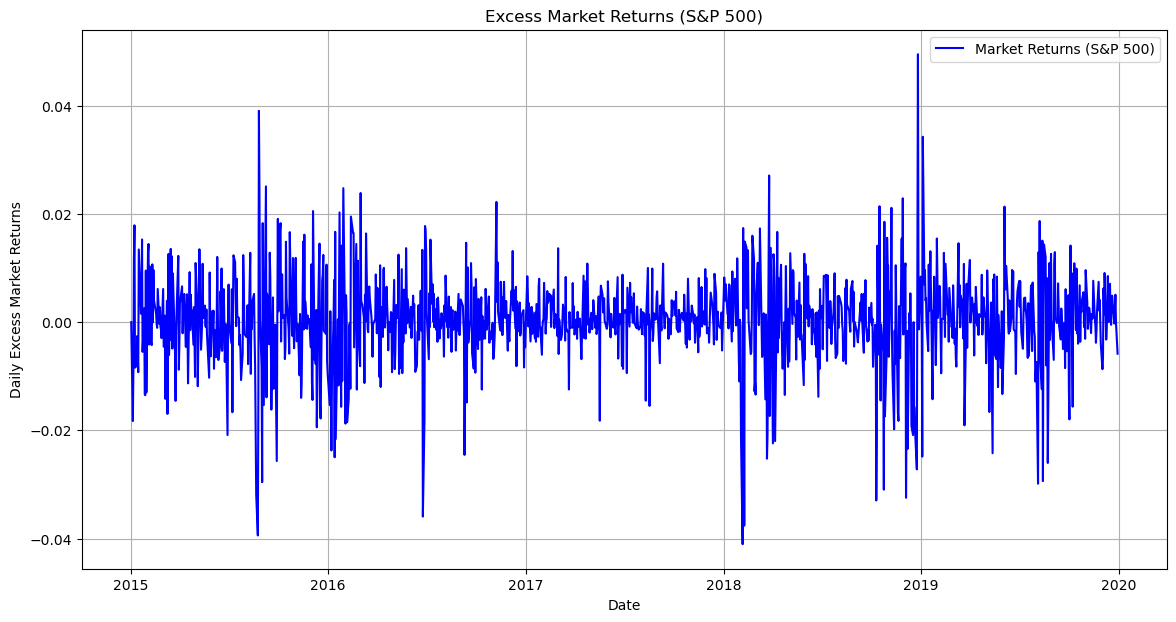

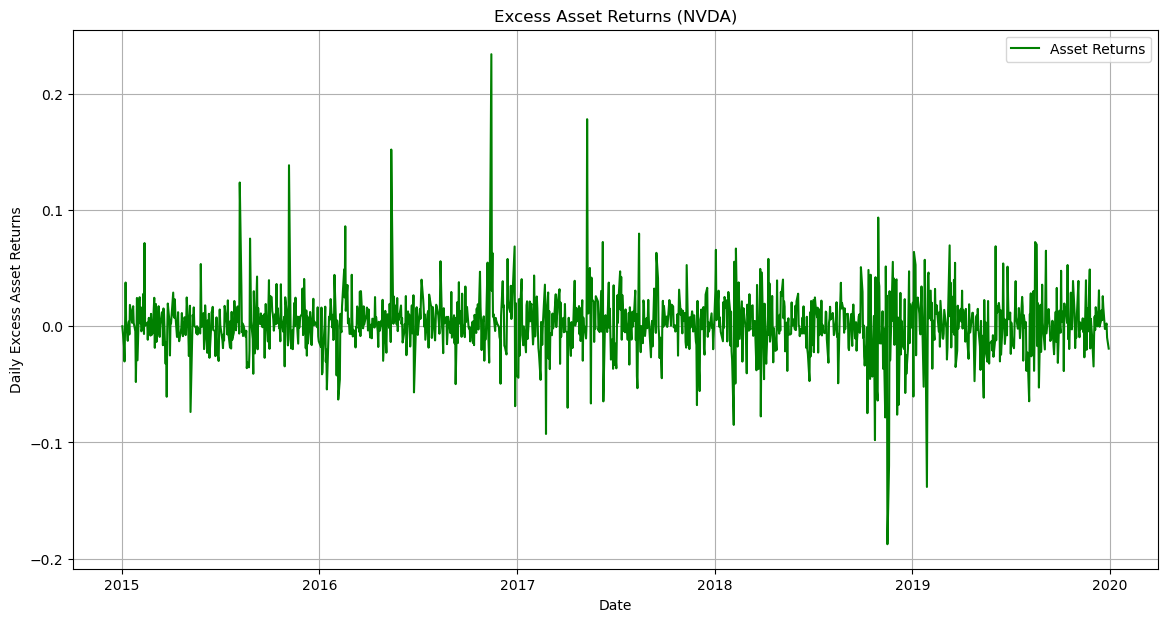

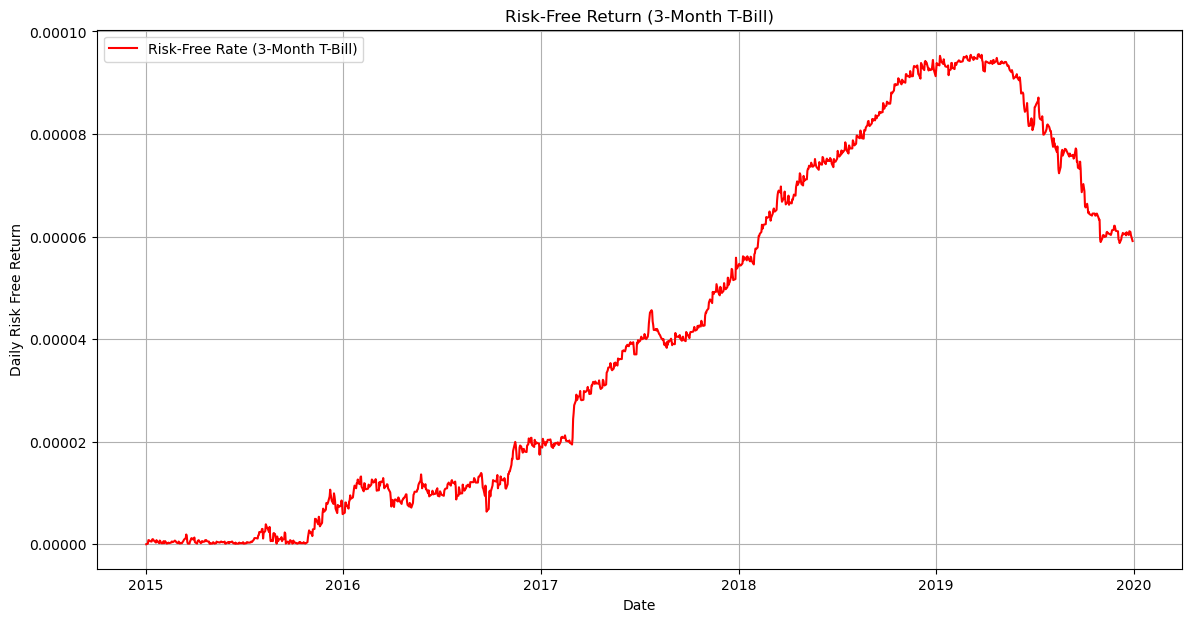

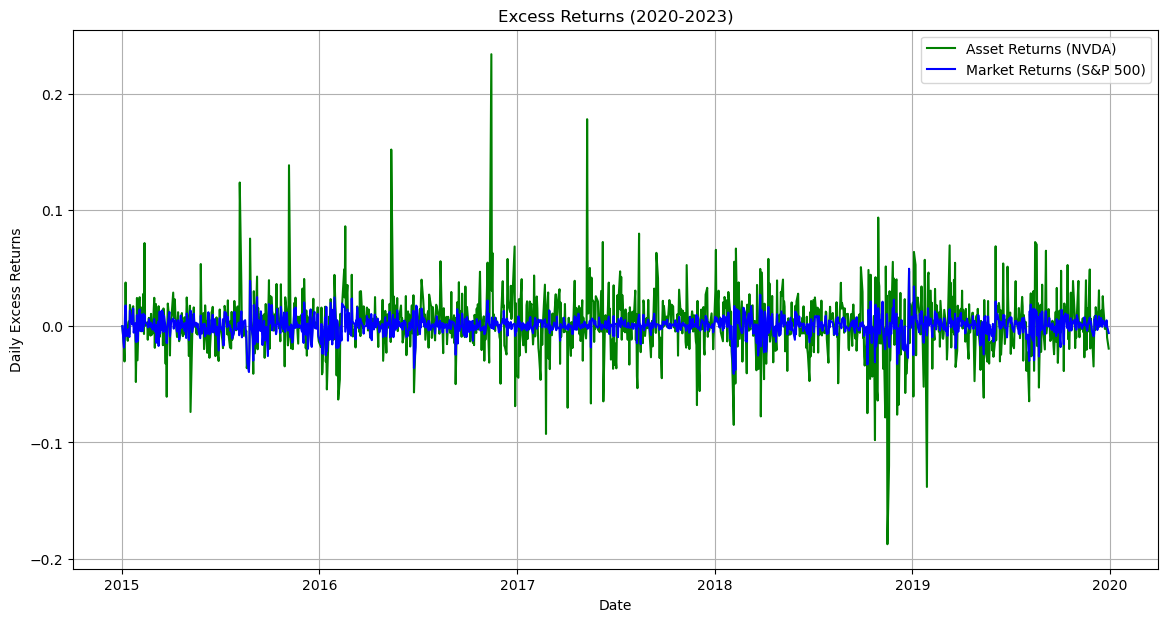

In [6]:

# Market Returns
plt.figure(figsize=(14, 7))
plt.plot(returns_df.index, returns_df['Excess_Market_Returns'], label='Market Returns (S&P 500)', color='blue')
plt.xlabel('Date')
plt.ylabel('Daily Excess Market Returns')
plt.title('Excess Market Returns (S&P 500)')
plt.legend()
plt.grid(True)
plt.show()

# Asset Returns
plt.figure(figsize=(14, 7))
plt.plot(returns_df.index, returns_df['Excess_Asset_Returns'], label='Asset Returns', color='green')
plt.xlabel('Date')
plt.ylabel('Daily Excess Asset Returns')
plt.title('Excess Asset Returns (NVDA)')
plt.legend()
plt.grid(True)
plt.show()

# Risk-Free Rate
plt.figure(figsize=(14, 7))
plt.plot(returns_df.index, returns_df['Risk_Free_Rate'], label='Risk-Free Rate (3-Month T-Bill)', color='red')
plt.xlabel('Date')
plt.ylabel('Daily Risk Free Return')
plt.title('Risk-Free Return (3-Month T-Bill)')
plt.legend()
plt.grid(True)
plt.show()

# Market and Asset returns combined to put into report
plt.figure(figsize=(14, 7))
plt.plot(returns_df.index, returns_df['Excess_Asset_Returns'], label='Asset Returns (NVDA)', color='green')
plt.plot(returns_df.index, returns_df['Excess_Market_Returns'], label='Market Returns (S&P 500)', color='blue')
plt.xlabel('Date')
plt.ylabel('Daily Excess Returns')
plt.title('Excess Returns (2020-2023)')
plt.legend()
plt.grid(True)
plt.show()


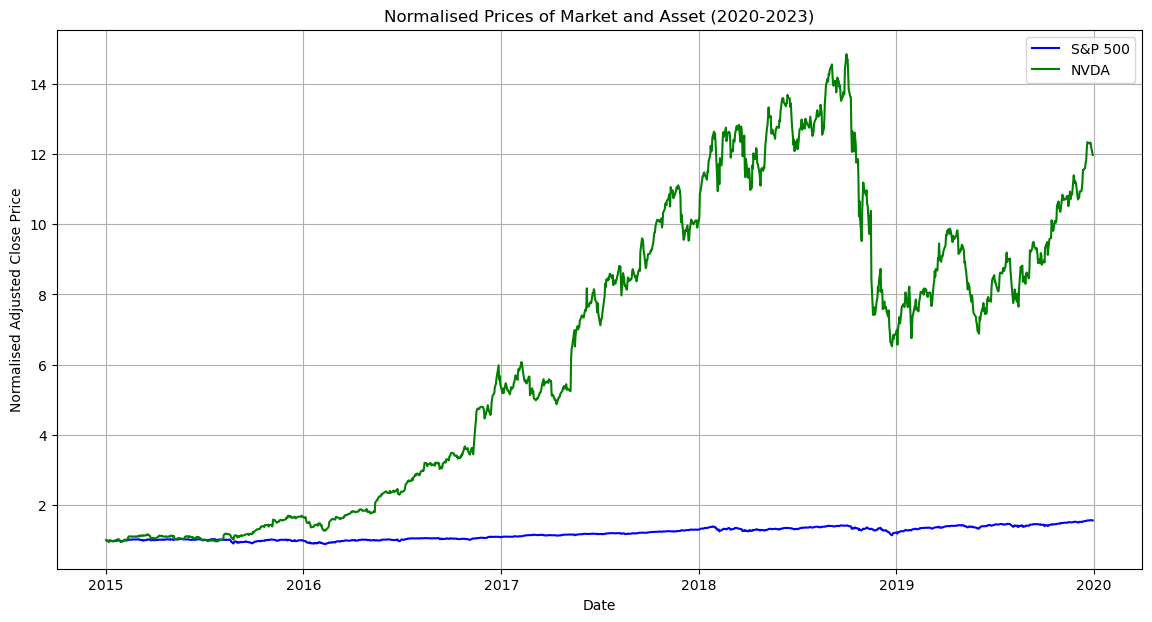

In [7]:
# Combine data into a single DataFrame
prices_df = pd.concat([market_returns, asset_returns, rf_daily], axis=1, join='inner')
prices_df.index.name = "Date"

def normalize_prices(df):
        """
        Normalizes the log prices to start at 1.
        
        Parameters:
        df (pd.DataFrame): DataFrame containing log prices.
        
        Returns:
        pd.DataFrame: DataFrame with normalized log prices.
        """
        df_normalized = df.copy()
        for column in df_normalized.columns:
            df_normalized[column] = df[column] / df[column].iloc[0]
        return df_normalized

normalised_df = normalize_prices(prices_df)
# Plot Market Returns
plt.figure(figsize=(14, 7))
plt.plot(normalised_df.index, normalised_df['Market_Returns'], label='S&P 500', color='blue')
plt.plot(normalised_df.index, normalised_df['Asset_Returns'], label='NVDA', color='green')
plt.xlabel('Date')
plt.ylabel('Normalised Adjusted Close Price')
plt.title('Normalised Prices of Market and Asset (2020-2023)')
plt.legend()
plt.grid(True)
plt.show()


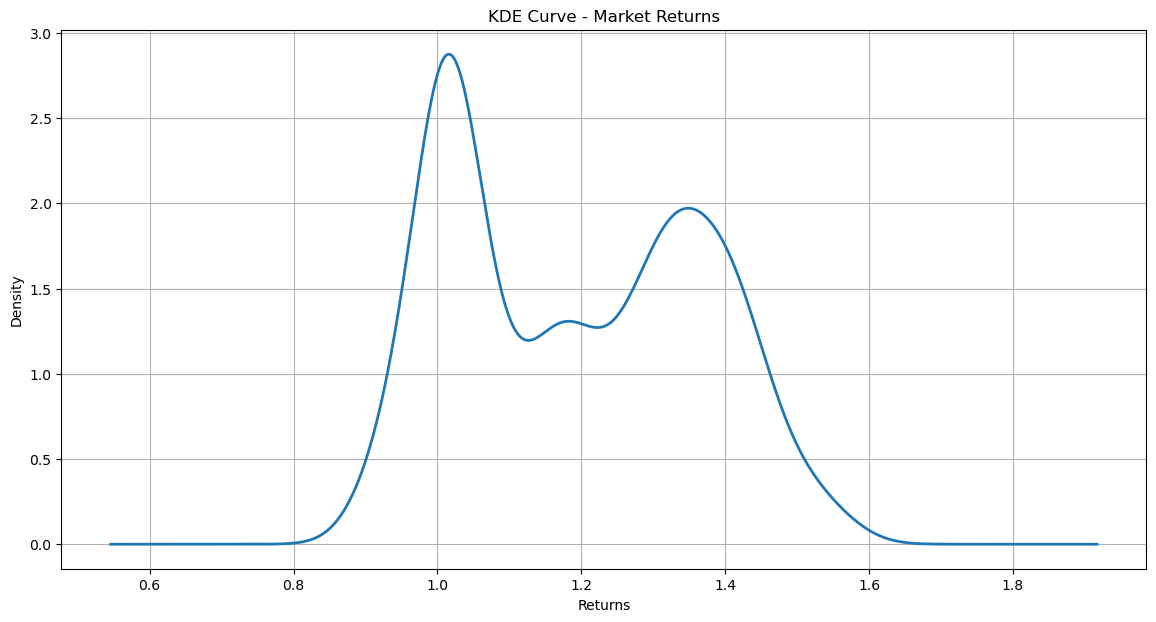

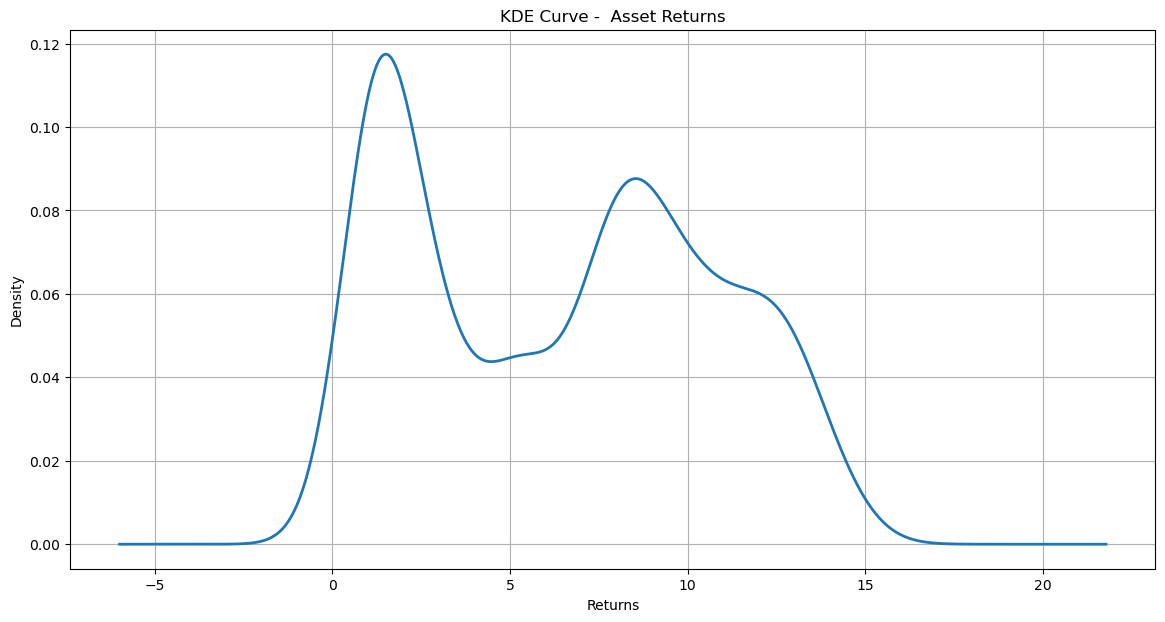

In [8]:
# Plotting the Kernel Density Estimate (KDE) for the first two columns
plt.figure(figsize=(14, 7))
normalised_df['Market_Returns'].plot.kde(linewidth=2)
plt.title('KDE Curve - Market Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plotting the Kernel Density Estimate (KDE) for the first two columns
plt.figure(figsize=(14, 7))
normalised_df['Asset_Returns'].plot.kde(linewidth=2)
plt.title('KDE Curve -  Asset Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.grid(True)
plt.show()



#### the above normalised data for market and asset is to show that the general trend for the asset is it somewhat following the trend of the market, but becomes little erratic in the later periods. The kernal density garphs shows the log returns on not normally distributed which is common trait for financial data. Later tests for stationarity and autocorrelation will be done to see what kind of base model should be used to have a baseline

In [9]:
# Create a new DataFrame to store the excess log returns
excess_returns_df = returns_df[['Excess_Market_Returns', 'Excess_Asset_Returns']].copy()

# Display the new DataFrame to ensure it's correctly populated


print("Excess Returns DataFrame:")


# Optionally, save this DataFrame to a CSV file if you want to keep a record or use it later
#excess_returns_df.to_csv('excess_returns.csv', index=True)
excess_returns_df.head(20)

Excess Returns DataFrame:


,Excess_Market_Returns,Excess_Asset_Returns
Date,,
2015-01-02,0.000000,0.000000
2015-01-05,-0.018278,-0.016890
2015-01-06,-0.008894,-0.030319
2015-01-07,0.011629,-0.002606
2015-01-08,0.017888,0.037617
2015-01-09,-0.008404,0.004028
2015-01-12,-0.008094,-0.012538
2015-01-13,-0.002579,-0.001525
2015-01-14,-0.005814,0.004068


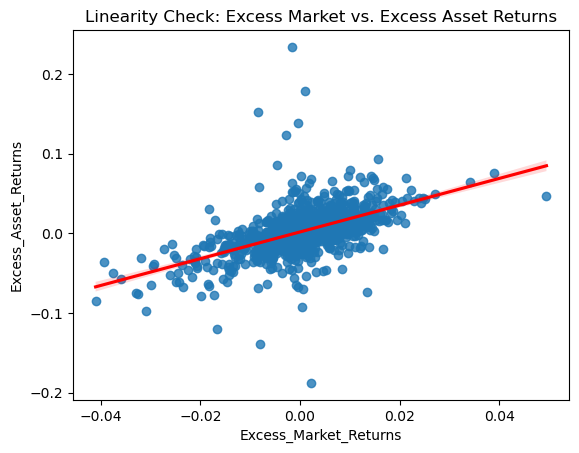

In [10]:
# Linearity Check
sns.regplot(x='Excess_Market_Returns', y='Excess_Asset_Returns', data=excess_returns_df, line_kws={'color': 'red'})
plt.title('Linearity Check: Excess Market vs. Excess Asset Returns')
plt.show()

### In order to handle outliers, z-score handling is being used.

In [11]:


# Calculate Z-scores
z_scores = stats.zscore(excess_returns_df[['Excess_Market_Returns', 'Excess_Asset_Returns']])

# threshold for Z-scores
threshold = 3  

# Filter out outliers based on Z-score
filtered_excess_returns_df = excess_returns_df[(np.abs(z_scores) < threshold).all(axis=1)]

print(f"Data retained after Z-score filtering: {len(filtered_excess_returns_df)} out of {len(excess_returns_df)}")


Data retained after Z-score filtering: 1224 out of 1256


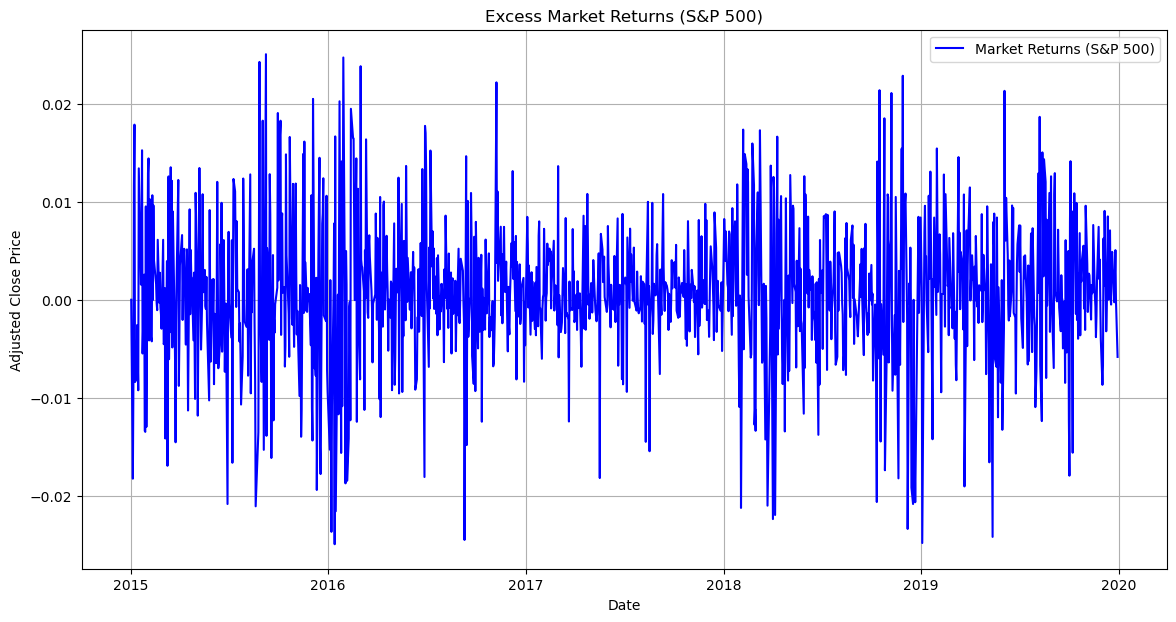

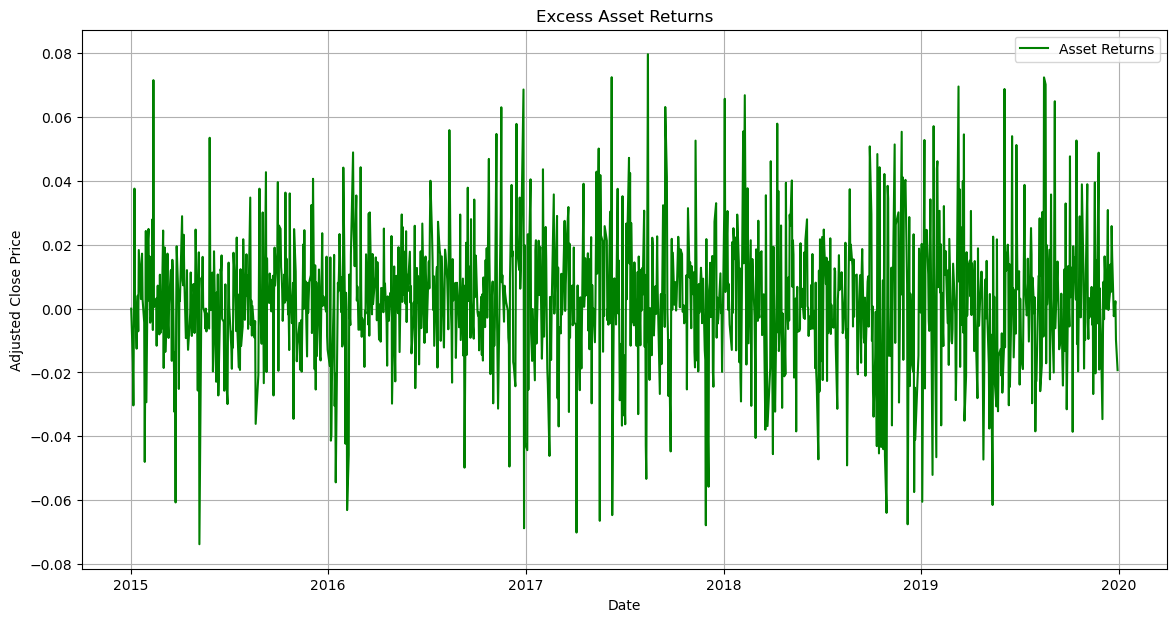

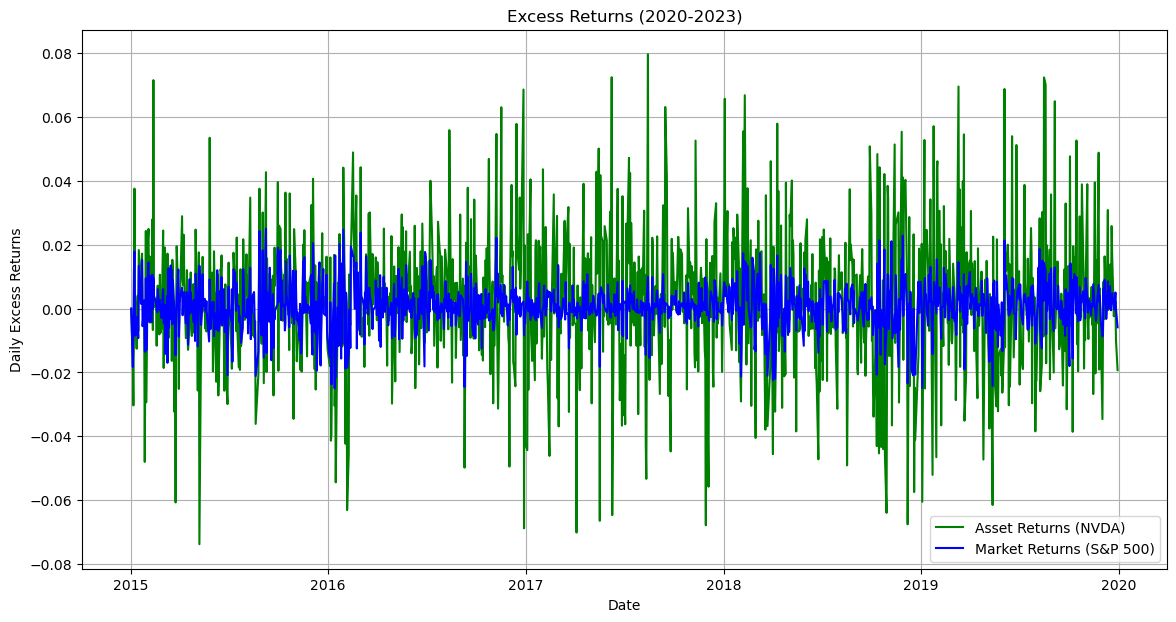

In [12]:


# Plot Market Returns
plt.figure(figsize=(14, 7))
plt.plot(filtered_excess_returns_df.index, filtered_excess_returns_df['Excess_Market_Returns'], label='Market Returns (S&P 500)', color='blue')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Excess Market Returns (S&P 500)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Asset Returns
plt.figure(figsize=(14, 7))
plt.plot(filtered_excess_returns_df.index, filtered_excess_returns_df['Excess_Asset_Returns'], label='Asset Returns', color='green')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Excess Asset Returns')
plt.legend()
plt.grid(True)
plt.show()

# Market and Asset returns combined to put into report
plt.figure(figsize=(14, 7))
plt.plot(filtered_excess_returns_df.index, filtered_excess_returns_df['Excess_Asset_Returns'], label='Asset Returns (NVDA)', color='green')
plt.plot(filtered_excess_returns_df.index, filtered_excess_returns_df['Excess_Market_Returns'], label='Market Returns (S&P 500)', color='blue')
plt.xlabel('Date')
plt.ylabel('Daily Excess Returns')
plt.title('Excess Returns (2020-2023)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
filtered_excess_returns_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1224 entries, 2015-01-02 to 2019-12-30
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Excess_Market_Returns  1224 non-null   float64
 1   Excess_Asset_Returns   1224 non-null   float64
dtypes: float64(2)
memory usage: 28.7 KB


### Linearity Check after Outlier handling

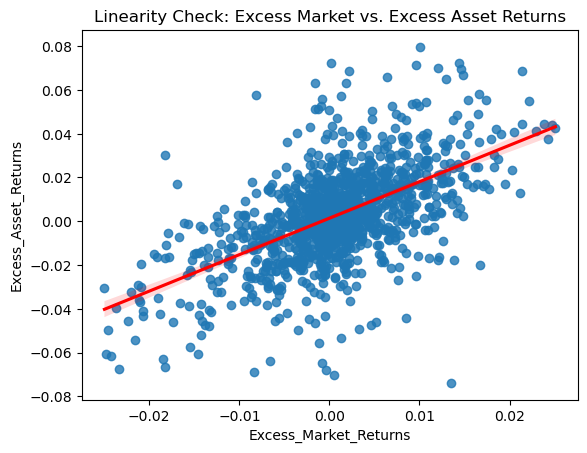

In [14]:

sns.regplot(x='Excess_Market_Returns', y='Excess_Asset_Returns', data=filtered_excess_returns_df, line_kws={'color': 'red'})
plt.title('Linearity Check: Excess Market vs. Excess Asset Returns')
plt.show()

## Tests to check the data is suitable for modelling

---
#### Stationarity Test

In [15]:


adf_market = adfuller(filtered_excess_returns_df['Excess_Market_Returns'])
adf_asset = adfuller(filtered_excess_returns_df['Excess_Asset_Returns'])

print(f'Market ADF Statistic: {adf_market[0]}')
print(f'Market p-value: {adf_market[1]}')
print(f'Asset ADF Statistic: {adf_asset[0]}')
print(f'Asset p-value: {adf_asset[1]}')


Market ADF Statistic: -37.45526701119536
Market p-value: 0.0
Asset ADF Statistic: -36.81330884910252
Asset p-value: 0.0


#### The Augmented Dickey-Fuller (ADF) test checks whether the time series is stationary. A stationary series has constant mean and variance over time, which is important for reliable time series modelling. A p-value of 0 above indicates that the series is stationary, making it suitable for modelling.

---
#### Normality test of Residuals

In [16]:


# Preliminary OLS regression
X = sm.add_constant(filtered_excess_returns_df['Excess_Market_Returns'])
model = sm.OLS(filtered_excess_returns_df['Excess_Asset_Returns'], X).fit()
residuals = model.resid

# Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)
print(f'Shapiro-Wilk p-value: {shapiro_test.pvalue}')


Shapiro-Wilk p-value: 1.1048982578813608e-15


#### The Shapiro-Wilk test assesses whether the residuals from the model follow a normal distribution. Normality of residuals is an assumption for many models, and deviations from this may suggest the need for transformations or robust models to handle non-normality. Although Transformers such as Box-Cox, PowerTransformers were used in prilimiary exploration stages but it wasn't fruitful. Additionaly, in order to retain the essence of Financial data, which are generally non-normal on high frequency data, a decision was made to work with this only.

---
#### Autocorrelation Check

In [17]:


dw_statistic = durbin_watson(residuals)
print(f'Durbin-Watson Statistic: {dw_statistic}')


Durbin-Watson Statistic: 2.082115162030288


#### The Durbin-Watson test checks for autocorrelation in the residuals. Autocorrelation can indicate that the residuals are not independent, violating one of the key assumptions of OLS. A value close to 2 suggests little to no autocorrelation.

---
#### Heteroscedasticity Check

In [18]:


lm_test = het_breuschpagan(residuals, X)
print(f'Breusch-Pagan p-value: {lm_test[1]}')


Breusch-Pagan p-value: 0.2589464056909178


#### The Breusch-Pagan test detects heteroscedasticity, which occurs when the variance of residuals is not constant. Heteroscedasticity can affect the efficiency of estimators, so failing to detect it (i.e., a high p-value) indicates that the residuals are homoscedastic, which is desired in regression models.

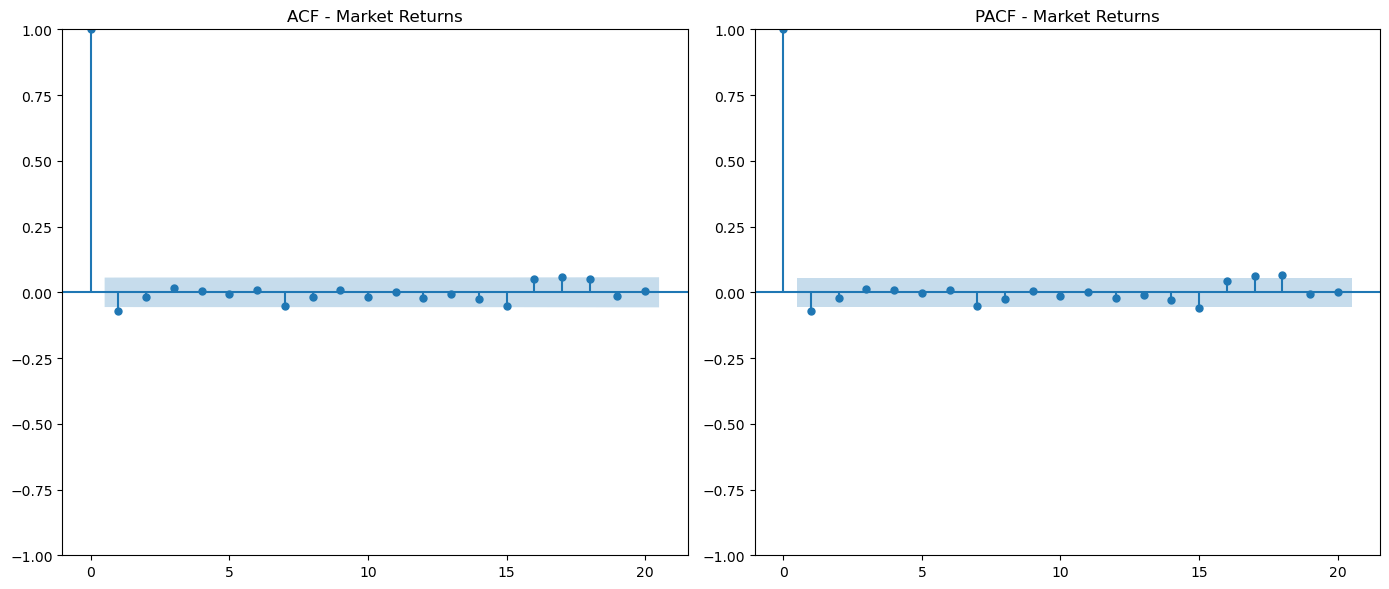

In [19]:

# Plot ACF and PACF for market returns
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(filtered_excess_returns_df['Excess_Market_Returns'], lags=20, ax=plt.gca(), title="ACF - Market Returns")

plt.subplot(1, 2, 2)
plot_pacf(filtered_excess_returns_df['Excess_Market_Returns'], lags=20, ax=plt.gca(), title="PACF - Market Returns")

plt.tight_layout()
plt.show()


### as it can be seen from the tests that the data is now stationary, but the residuals possess non-normality, which is generally normal to see for financial data as the asset are generally connected to market movement, and considering that the market I've used as S&P500 index. This, on the other hand, to my knowledge, this does not break any conditions/assumptions for the Models that I will be testing further for beta estimation and hence for real-world scenario, the models performance will be checked with experimental analysis and then compared for both models stated.

In [20]:
# Create a new DataFrame with the transformed columns to work with them more easily

transformed_df = filtered_excess_returns_df[['Excess_Market_Returns', 
                                             'Excess_Asset_Returns']].copy()

# Rename the columns to simpler names
transformed_df.rename(columns={
    'Excess_Market_Returns': 'Market_Returns',
    'Excess_Asset_Returns': 'Asset_Returns'
}, inplace=True)

# saving the dataframe to csv to then straight away use in our Model jupyter notebook
transformed_df.to_csv('transformed_returns_(2015-2019).csv', index=True)

transformed_df.head(15)


,Market_Returns,Asset_Returns
Date,,
2015-01-02,0.000000,0.000000
2015-01-05,-0.018278,-0.016890
2015-01-06,-0.008894,-0.030319
2015-01-07,0.011629,-0.002606
2015-01-08,0.017888,0.037617
2015-01-09,-0.008404,0.004028
2015-01-12,-0.008094,-0.012538
2015-01-13,-0.002579,-0.001525
2015-01-14,-0.005814,0.004068


---
---
---
---